## a)

In [8]:
from matplotlib import pyplot as plt

def show_image(img, title):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

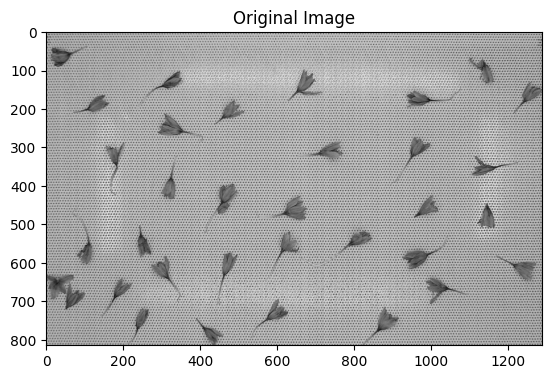

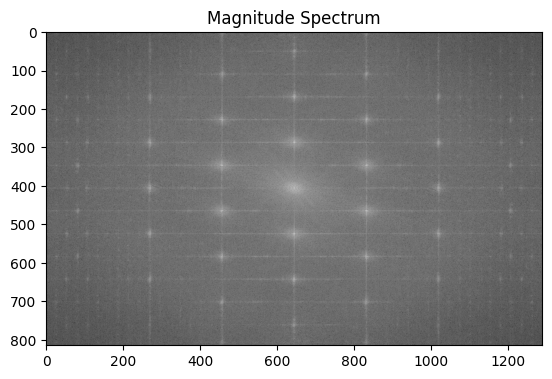

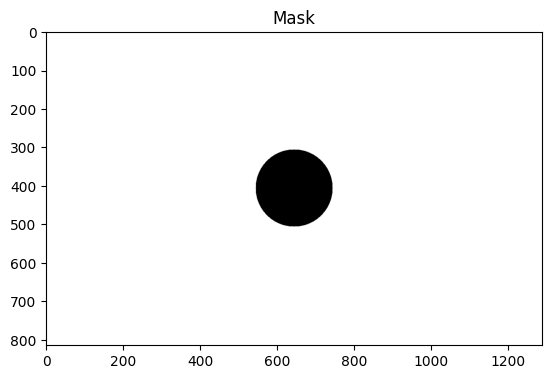

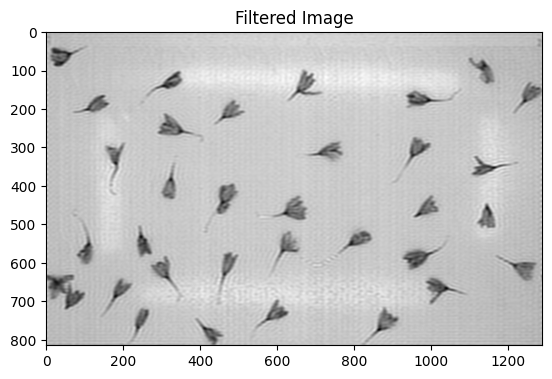

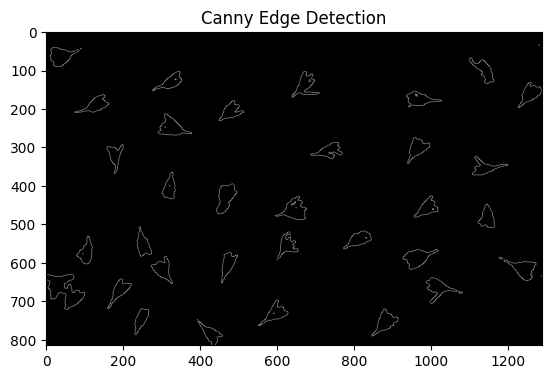

In [11]:

import cv2 as cv2
import numpy as np
from matplotlib import pyplot as plt

# Define a function to show images
def show_image(img, title):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()
    
def remove_noise_fft(img):
    returns = [(img, "Original Image")]
    
    # Apply Fourier Transform
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    returns.append((magnitude_spectrum, "Magnitude Spectrum"))
    
    # Create a mask
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[:, :] = 1
    r = 100
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0])**2 + (y - center[1])**2 <= r*r
    mask[mask_area] = 0
    returns.append((mask*255, "Mask"))
    
    # Apply the mask
    fshift_filtered = fshift * (1 - mask)
    fshift_filtered_shifted = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(fshift_filtered_shifted)
    img_back = np.real(img_back)
    returns.append((img_back, "Filtered Image"))

    # Apply Canny edge detection
    img_canny = img_back.copy()
    threshold = 127
    img_canny[img_canny < threshold] = 0
    img_canny[img_canny >= threshold] = 255
    canny = cv2.Canny(img_canny.astype(np.uint8), 70, 100)
    returns.append((canny, "Canny Edge Detection"))
    
    return returns
    
img = cv2.imread("images/saffrun.jpg", 0)
imgs = remove_noise_fft(img)
for i in imgs:
    show_image(i[0], i[1])


In [ ]:

z = '.'
arrowsl1 = ['→', '↗️', '↑', '↖️', '←', '↙️', '↓', '↘️']
arrowsl2 = ['➡️', '⬈', '⬆️', '⬉', '⬅️', '⬋', '⬇️', '⬊']
arrows = [z, arrowsl1, arrowsl2]

def angel2arrow(d, s, mean): # d: direction - s: size - mean: avg of sizes
    # here you can change the precision of each level of arrows by size
    arrowIndex = int(d/(365/8))
    if s <= mean/100:
        return arrows[0]
    elif s > mean:
        return arrows[2][arrowIndex]
    elif s <= mean:
        return arrows[1][arrowIndex]

def gradientDir2gradientArrow(gd, gs): # gd: gradient directions - gs: gradient sizes
    gd = gd +360
    gd = gd % 360
    gd = gd + 22.5
    gd = gd % 360
    mean = gs.sum() / np.count_nonzero(gs)
    result = [['' for j in range(len(gd[0]))] for i in range(len(gd))]
    for i in range(len(gd)):
        for j in range(len(gd[0])):
            result[i][j] = angel2arrow(gd[i][j], gs[i][j], mean)
    return result

def makeGradientArrow(img):
    """ makes gradient matrices with a little change in them to 
        correct the angle of directions. 
        because of the difference in axes of image and math functions, 
        the arctan2 result is wrong by default """
    Gx, Gy = np.gradient(img)
    Gx = -Gx
    gd = np.arctan2(Gx, Gy) * 180 / np.pi
    gd = (gd + 180) % 360
    gs = np.sqrt(Gx*Gx + Gy*Gy)
    ga = gradientDir2gradientArrow(gd, gs)
    return ga

def printGradientArrows(filepath, ga):
    """ prints ga in the file path specified """
    with open(filepath, 'w', encoding="utf-8") as file:
        for i in range(len(ga)):
            file.write(' '.join(ga[i]) + '\n')


ga = makeGradientArrow(borders)
printGradientArrows('images/Q2/imageArrows.txt' ,ga)

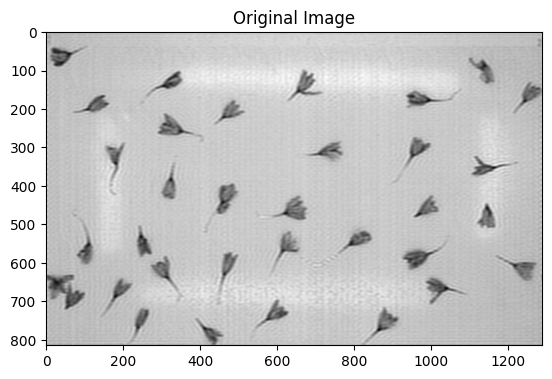

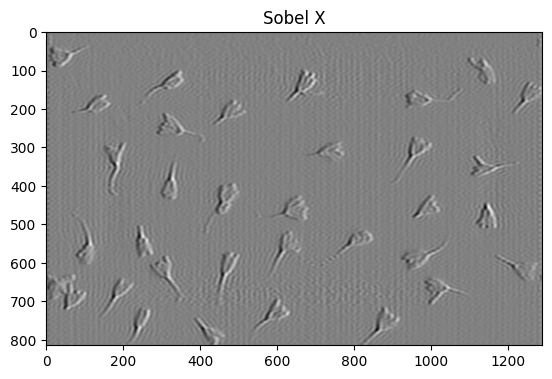

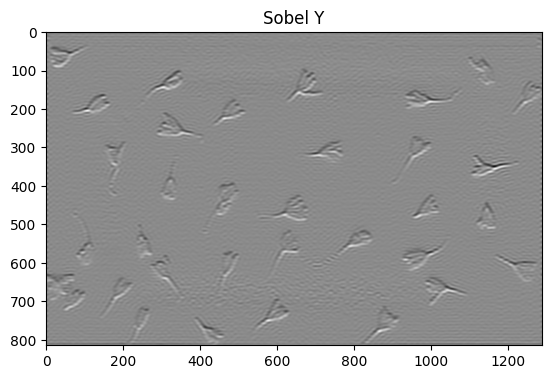

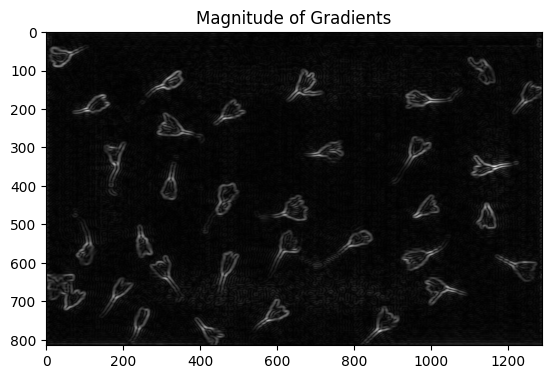

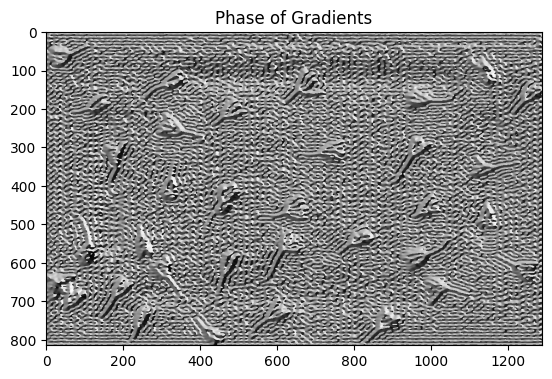

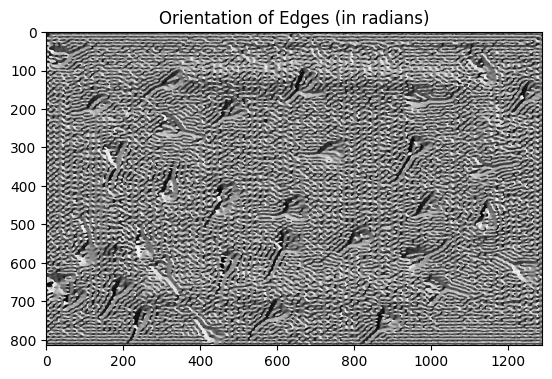

In [17]:
img_back = imgs[3][0]

# Compute gradients in x and y direction
sobelx = cv2.Sobel(img_back, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(img_back, cv2.CV_64F, 0, 1, ksize=5)

# Convert gradients to magnitude and phase
mag, phase = cv2.cartToPolar(sobelx, sobely)

# Calculate orientation of edges in radians
orientation = np.arctan2(sobely, sobelx)


show_image(img_back, 'Original Image')
show_image(sobelx, 'Sobel X')
show_image(sobely, 'Sobel Y')
show_image(mag, 'Magnitude of Gradients')
show_image(phase, 'Phase of Gradients')
show_image(orientation, 'Orientation of Edges (in radians)')